In [202]:
include("read_nu_dist_sphere.jl")
# include("read_eff_area.jl")
# include("read_energy_res.jl")
include("functions_utils.jl")

# Packages

using DelimitedFiles
using StatsBase
using Interpolations
using Plots
using LaTeXStrings
using FFTW
using Distributions
using Profile
using PyCall
using SpecialFunctions
using Optim
using StaticArrays
using Healpix
using BenchmarkTools
using CurveFit

# Importing the necessary python libraries
@pyimport matplotlib.pyplot as plt
@pyimport numpy as np
@pyimport healpy as hp

In [203]:
# Read eff area

eff_a = readdlm("gc_data/km3net_effarea.csv", ',')
effarea_non_extrap = Interpolations.interpolate(((10 .^ eff_a[:, 1]),), (10 .^ eff_a[:, 2]), Gridded(Linear())) # in m^2
effarea = extrapolate(effarea_non_extrap, 0.0)

# The min and max energy vals (in TeV) we consider based on the limits of the effective area function
emin = 10^(eff_a[1, 1])
emax = 10^(eff_a[31, 1])

loges = range(log10(emin), log10(emax), 200)
du = loges[2] - loges[1]

#Read ang res

ang_res = readdlm("gc_data/km3net_angres.csv", ',')

angres_non_extrap = Interpolations.interpolate(((10 .^ ang_res[:, 1]),), ang_res[:, 2], Gridded(Linear())) # in m^2
angres = extrapolate(angres_non_extrap, 0.0)
;

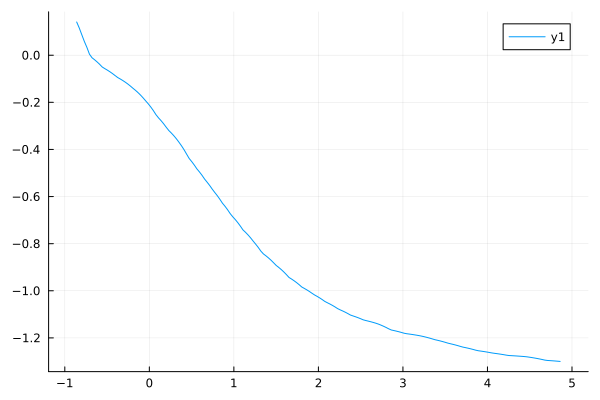

In [324]:
plot(
    loges,
    log10.(angres.(10 .^ loges))
)

In [248]:
# IceCube eff area

eff_a_ic = readdlm("gc_data/EffA_GC_approx_2.csv", ',')
effarea_non_extrap_ic = Interpolations.interpolate((eff_a_ic[:, 1] ./ 1000,), eff_a_ic[:, 2], Gridded(Linear())) # in m^2
effarea_ic = extrapolate(effarea_non_extrap_ic, 0.0)

# The min and max energy vals (in TeV) we consider based on the limits of the effective area function
emin_ic = 0.7249213596719925
emax_ic = 1099.9079675727165

1099.9079675727164

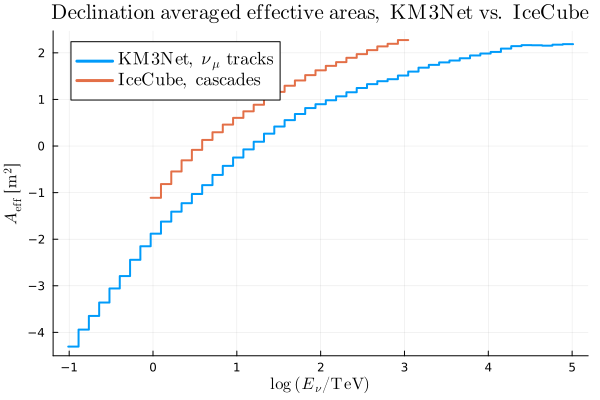

In [255]:
logerange = range(log10(emin), log10(emax), 50)
plot(
    logerange,
    [log10.(effarea.(10 .^ logerange)) log10.(effarea_ic.(10 .^ logerange))],
    seriestype=:step,
    label=[L"\textrm{KM3Net,~}\nu_{\mu}~\textrm{tracks}" L"\textrm{IceCube,~cascades}"],
    xlabel=L"\log~(E_\nu / \textrm{TeV})",
    ylabel=L"A_{\mathrm{eff}}~[\mathrm{m^2}]",
    title=L"\textrm{Declination~averaged~effective~areas,~KM3Net~vs.~IceCube}",
    legendfontsize=12,
    lw=2
)

In [204]:
# Loading the models and necessary data

model = "galnu_GALcase2"

# Getting spatial data
rs, ls, bs, rweights, logνes, logCRes = read_models(model)
oneweights = Weights(ones(length(rweights)))

# Getting the (previously unneeded) energy gc_data
minlogCRe, maxlogCRe = minimum(logCRes), maximum(logCRes)
logCRebins = range(minlogCRe, maxlogCRe, 100)

minlogνe, maxlogνe = minimum(logνes), maximum(logνes)
logνebins = range(minlogνe, maxlogνe, 100)
;

In [205]:
# Cut all neutrinos outside our effective area energy bounds

function energy_cut(rs, ls, bs, rweights, logνes, oneweights)
    concatmat = hcat(rs, ls, bs, rweights, logνes, oneweights)
    filtered_matrix_rows = [row for row in eachrow(concatmat) if log10(emin) <= row[5] <= log10(emax)]
    filtered_mat = hcat(filtered_matrix_rows...)
    fmat = transpose(filtered_mat)
end

cut = energy_cut(rs, ls, bs, rweights, logνes, oneweights)
rs, ls, bs, rweights, logνes, oneweights = cut[:,1], cut[:,2], cut[:,3], cut[:,4], cut[:,5], cut[:,6]
;

In [379]:
# Functions that smear the Monte Carlo

function angsmearMC(ls, bs, logνes)
    numν = length(ls)
    ls_sm = zeros(numν)
    bs_sm = zeros(numν)

    for i in 1:numν
        dist = MvNormal([ls[i], bs[i]], (π/180) * angres(10^(logνes[i])))
        l_sm, b_sm = rand(dist, 1)

        # Changing the coordinates to fit in the \ell, b bounds
        if b_sm > π/2
            b_sm = π - b_sm
            if l_sm > 0
                l_sm -= π
            else
                l_sm += π
            end
        end
        if b_sm < -π/2
            b_sm = -π - b_sm
            if l_sm > 0
                l_sm -= π
            else
                l_sm += π
            end
        end

        if l_sm > π
            l_sm -= 2π
        end
        if l_sm < -π
            l_sm += 2π
        end
            
        ls_sm[i] = l_sm
        bs_sm[i] = b_sm
    end
    return (ls_sm, bs_sm)
end

angsmearMC (generic function with 1 method)

In [380]:
ls_sm, bs_sm = angsmearMC(ls, bs, logνes);

In [208]:
function normdist(loges)

    loges = range(log10(emin), log10(emax), 200)
    du = loges[2] - loges[1]

    comb_vec = [zeros(200) for _ in 1:200]

    for i in 1:200
        d(x) = pdf(Normal(loges[i], 0.3), x)
        smearvec = d.(loges) .* du

        # normalize
        normconst = sum(smearvec)
        smearvec = smearvec ./ normconst

        comb_vec[i] = smearvec
    end

    return hcat(comb_vec...)

end

normdist (generic function with 1 method)

In [209]:
energymat = normdist(loges);

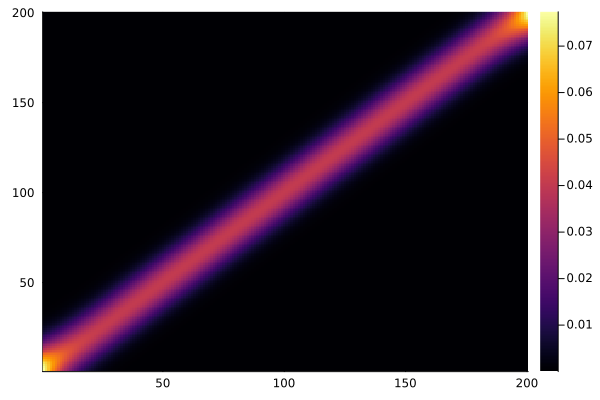

In [367]:
heatmap(energymat)

In [210]:
function oscprob(et, dm2, leff)

    # Norms squared of the PMNS matrix (exact vals might change but always needs to be unitary)
    u = @SMatrix [0.674743 0.302844 0.0224125;
                  0.0946105 0.360415 0.544974;
                  0.230646 0.33674 0.432613]

    # Conversion factor to go from kpc to 1/eV
    convfactor = 3.086e19 * 5.06773093741 * 1e6

    leff *= convfactor

    # Assuming uniform mass splitting over all three mass states
    osc = (cos((dm2 * leff)/(4*et*1e12)))^2

    # prob_ee = osc*((u[1]*u[1]) + (u[4]*u[4]) + (u[7]*u[7]))
    # prob_μe = osc*((u[1]*u[2]) + (u[4]*u[5]) + (u[7]*u[8]))

    # prob_eτ = osc*((u[3]*u[1]) + (u[6]*u[4]) + (u[9]*u[7]))
    # prob_μτ = osc*((u[3]*u[2]) + (u[6]*u[5]) + (u[9]*u[8]))

    prob_eμ = osc*((u[2]*u[1]) + (u[5]*u[4]) + (u[8]*u[7]))
    prob_μμ = osc*((u[2]*u[2]) + (u[5]*u[5]) + (u[8]*u[8]))
    # prob_τμ = osc*((u[2]*u[3]) + (u[5]*u[6]) + (u[8]*u[9]))

    # prob_e = 0.333333prob_ee + 0.666666prob_μe
    # prob_τ = 0.333333prob_eτ + 0.666666prob_μτ
    prob_μ = 0.333333prob_eμ + 0.666666prob_μμ

    # νμ contribution comes from the 25% chance of a neutral current interaction, which appears as a cascade
    # prob_μ_track = prob_e + prob_τ + 0.25prob_μ
end

function dm2stuff(dm2)
    ers = 10 .^ loges
    rbins = range(0, 20, 200)

    # effareavec = effarea.(ers) * 10000
    oscprobmat = [oscprob(er, dm2, rbin) for rbin in rbins, er in ers]

    return oscprobmat .* transpose(effareavec)

end

# Energy ranges and getting the effective area vector
ers = 10 .^ loges
effareavec = effarea.(ers) * 10000
;
# Smearing matrix with effective area


In [211]:
# Binning function that now bins energy as well

function weighthist_es(rs, ls, bs, loges, simws, fluxw; removed_bins=3, rbinsize=0.1, θbinsize=π/25, minloge=log10(emin), maxloge=log10(emax), elength=201, γ_inj=2.7)

    # Spatial reweighting
    rweights = Weights(simws ./ (rs .^ fluxw))

    # Energy reweighting
    power_law_flux(E, γ, ϕ₀=1, E0=1) = ϕ₀ * (E / E0)^(-γ)

    γ_sample = 1

    rweights .= Weights(rweights .* power_law_flux.( 10 .^ (loges), γ_inj - γ_sample))

    #=
    function calc_mc_PL_weights!(rweights, loges, γ_inj, γ_sample)
        # inj = target spectrum
        # sample = spectrum we sampled at
        rweights .*= power_law_flux.( 10 .^ (loges), γ_inj - γ_sample)
    end
    =#

    # We take square angular bins
    rbins, lbins, bbins, logebins = 0:rbinsize:20, -π:θbinsize:π, -π/2:θbinsize:π/2, range(minloge, maxloge, length=elength)

    # Histogramming the simulation by our radial and angular bins
    nuhist = Distributions.fit(Histogram, (rs, ls, bs, loges), rweights, (rbins, lbins, bbins, logebins), closed=:left)
    nuweights = nuhist.weights

    # removing bins to see what happens... (we expect very few neutrinos within 0.1 kpc from Earth, so it's set to 1)
    if removed_bins > 0
        nuweights[1:removed_bins, :, :, :] .= 0
    end

    return nuweights

end

weighthist_es (generic function with 1 method)

In [381]:
ebinning = weighthist_es(rs, ls_sm, bs_sm, logνes, rweights, 2, γ_inj=2.4)

200×49×24×200 Array{Float64, 4}:
[:, :, 1, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  

In [382]:
lbbin = ebinning[:, 25, 13, :];

In [268]:
gamma(x) = 200*x^(-1.8)
logerange = range(log10(emin), log10(emax), 200)

injspec = log10.(gamma.(10 .^ logerange));

In [334]:
# emin = 0.7249213596719925
# emax = 1099.9079675727165

read_spectrum_ic = vec(readdlm("espec_lbbin.txt"))

spectrum_non_extrap_ic = Interpolations.interpolate((range(log10(emin_ic), log10(emax_ic), 200),), read_spectrum_ic, Gridded(Linear())) # in m^2
spectrum_ic = extrapolate(spectrum_non_extrap_ic, 0.0)
;

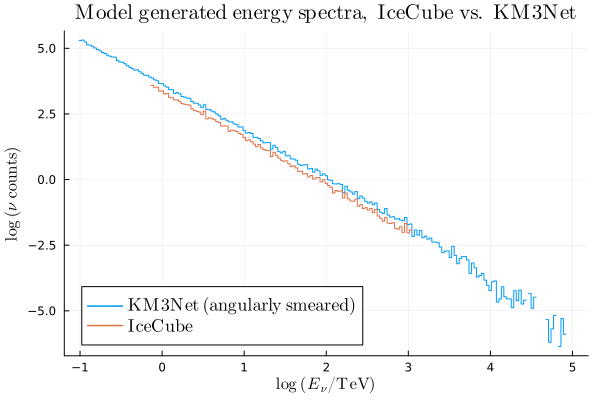

In [383]:
spectrum = vec(sum(lbbin, dims=1))
plot(
    loges,
    [log10.(spectrum) log10.(spectrum_ic.(loges))],
    seriestype=:step,
    xlabel=L"\log~(E_\nu / \textrm{TeV})",
    ylabel=L"\log~(\nu~\mathrm{counts})",
    label=[L"\mathrm{KM3Net~(angularly~smeared)}" L"\mathrm{IceCube}"],
    legendfontsize=12,
    title=L"\textrm{Model~generated~energy~spectra,~IceCube~vs.~KM3Net}"
)

In [329]:
fillermat = zeros(200, 200)

fillermat .= ebinning[:, 25, 13, :]

nulloscmat = dm2stuff(0)

matt_null = nulloscmat .* fillermat

null_unbs_edist = vec(sum(matt_null, dims=1)) # .* effareavec

null_unb_edist = energymat * null_unbs_edist 
;

In [330]:
fillermat .= ebinning[:, 25, 13, :]

altoscmat = dm2stuff(10^(-13.5))

matt_alt = altoscmat .* fillermat

alt_unbs_edist = vec(sum(matt_alt, dims=1)) # .* effareavec

alt_unb_edist = energymat * alt_unbs_edist
;

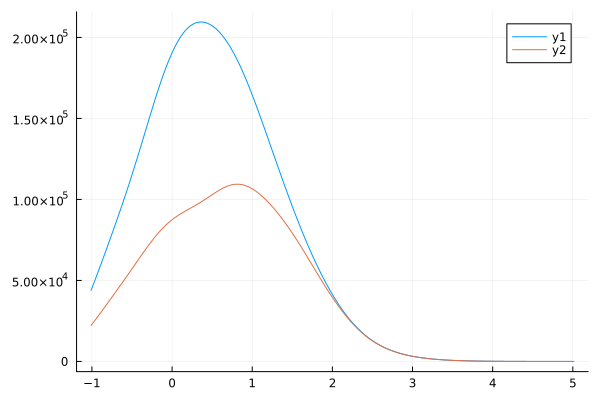

In [331]:
plot(
    range(log10(emin), log10(emax), 200),
    [null_unb_edist alt_unb_edist]
)

In [355]:
fluxnorm = 1.491819084323893e-6

function smeared_edist_binned(unbinned_edist; ϕ₀=fluxnorm)
    nbins = 25 # An admittedly arbitrary number of bins, should probably find a more intelligent number
    nsteps = 200
    vec = unbinned_edist .* du # .* (10 .^ loges) .* log(10)
    matrix = reshape(vec, (8, :)) # This 8 is the ratio nsteps/nbins
    sums = sum(matrix, dims=1) * ϕ₀ # * flxnorm # This normalizing factor is to make total as null events = 748
end

smeared_edist_binned (generic function with 1 method)

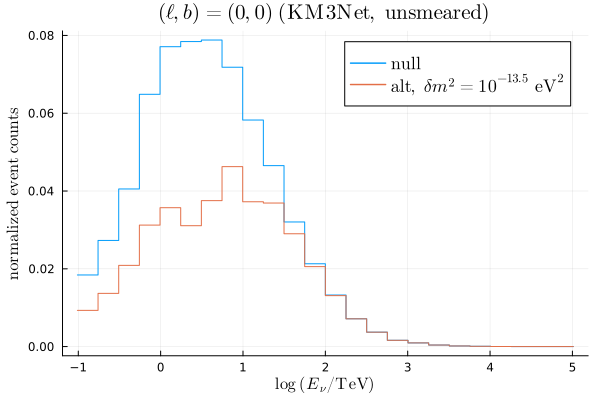

In [370]:
null_b_edist = vec(smeared_edist_binned(null_unbs_edist))
alt_b_edist = vec(smeared_edist_binned(alt_unbs_edist))

plot(
    range(log10(emin), log10(emax), 25),
    [null_b_edist alt_b_edist],
    seriestype=:step,
    xlabel=L"\log~(E_\nu / \mathrm{TeV})",
    ylabel=L"\textrm{normalized~event~counts}",
    label=[L"\textrm{null}" L"\textrm{alt},~\delta m^2 = 10^{-13.5}~\mathrm{eV^2}"],
    title=L"(\ell, b) = (0, 0)~(\textrm{KM3Net},~\textrm{unsmeared})",
    legendfontsize=12
)

In [342]:
bigmat = [ebinning[:, i, j, :] for i in 1:49, j in 1:24];

In [357]:
function allskyedists(bigmat, energymat, dm2)

    oscmat = dm2stuff(dm2)

    fillermat = zeros(200, 200)

    binnededistmat = [zeros(25) for _ in 1:24, _ in 1:49]

    for i in 1:24
        for j in 1:49

            fillermat .= bigmat[j, i]

            fillermat .*= oscmat

            unbs_edist = vec(sum(fillermat, dims=1)) 

            unb_edist = energymat * unbs_edist 

            binnededistmat[i, j] = vec(smeared_edist_binned(unb_edist, ϕ₀=fluxnorm))

        end
    end

    return binnededistmat
end

allskyedists (generic function with 1 method)

In [359]:
test_dist = allskyedists(bigmat, energymat, 0);

In [362]:
alt_test_dist = allskyedists(bigmat, energymat, 10^(-13.5));

In [360]:
sum(sum(test_dist))

28.184775265333474

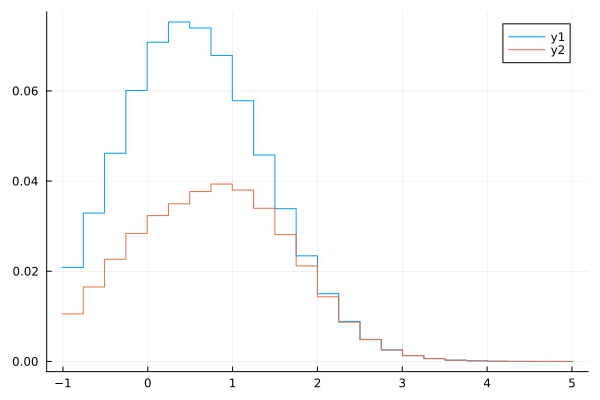

In [366]:
plot(
    range(log10(emin), log10(emax), 25),
    [test_dist[13, 25] alt_test_dist[13, 25]],
    seriestype=:step
)